# KNN Classification of Weather

## Introduction

Weather warnings are important forecasts because they are used to protect life and property. Especially in Seattle, a city that rains often, forecasts are made based on temperature, precipitation to help determine future climate expectations. These forecasts help business and farmers plan for power usage, irrigation and protection and also help people plan activities and dress for the weather accordingly. 
 
This model aims to answer the question: **can we classify weather using daily precipitation, wind speed and average temperature as predictors**? The data set we obtained (source: https://www.kaggle.com/ananthr1/weather-prediction) contains daily observations of weather in Seattle, Washington between 2012 to 2015. The set of variables per observation in this data set is:
- date: the date of the observation
- precipitation: the amount of precipitation in any form (cm)
- temp_max: the maximum temperature (Celsius)
- temp_min: the minimum temperature (Celsius)
- wind: the wind speed (mph)
- weather: the type of weather (drizzle, rain, sun, snow, fog)

By understanding the relationships among these variables, it helps meteorologists better predict the weather for the public. Note that the original data set did not provide units, so we made a reasonable guess for each variable. (For example, 10°C is more reasonable than 10°F for temperature)

## Exploring the Dataset

In [21]:
# Run this code to set up the notebook
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("knitr")
library(knitr)

also installing the dependency ‘xfun’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [30]:
# Read the data into R (provided by https://www.kaggle.com/ananthr1/weather-prediction)
weather_data <- read_csv("https://raw.githubusercontent.com/irisxu02/dsci100-group13/main/weather.csv") %>%
    mutate(weather = as_factor(weather),
           temp_avg = (temp_max + temp_min)/2)
weather_data

Parsed with column specification:
cols(
  date = col_date(format = ""),
  precipitation = col_double(),
  temp_max = col_double(),
  temp_min = col_double(),
  wind = col_double(),
  weather = col_character()
)



date,precipitation,temp_max,temp_min,wind,weather,temp_avg
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
2012-01-01,0.0,12.8,5.0,4.7,drizzle,8.90
2012-01-02,10.9,10.6,2.8,4.5,rain,6.70
2012-01-03,0.8,11.7,7.2,2.3,rain,9.45
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2015-12-29,0,7.2,0.6,2.6,fog,3.90
2015-12-30,0,5.6,-1.0,3.4,sun,2.30
2015-12-31,0,5.6,-2.1,3.5,sun,1.75


Now that we have tidy data, we would like to perform a summary to see how many observations of each type of weather we have. Is our data evenly distributed? 

In [31]:
# Count the number of observations for each weather type
weather_data_count <- weather_data %>%
    group_by(weather) %>%
    summarize(n = n())
kable(weather_data_count, caption = "The number of observations recorded for each type of weather")

`summarise()` ungrouping output (override with `.groups` argument)





Table: The number of observations recorded for each type of weather

|weather |   n|
|:-------|---:|
|drizzle |  53|
|rain    | 641|
|sun     | 640|
|snow    |  26|
|fog     | 101|

Our data is highly unbalanced with respect to our predictor variable. For this reason, we will upsample the rare weather in our data analysis.

### Visualization

We want to provide a plot of the data so we can get a visual overview of what we are working with.

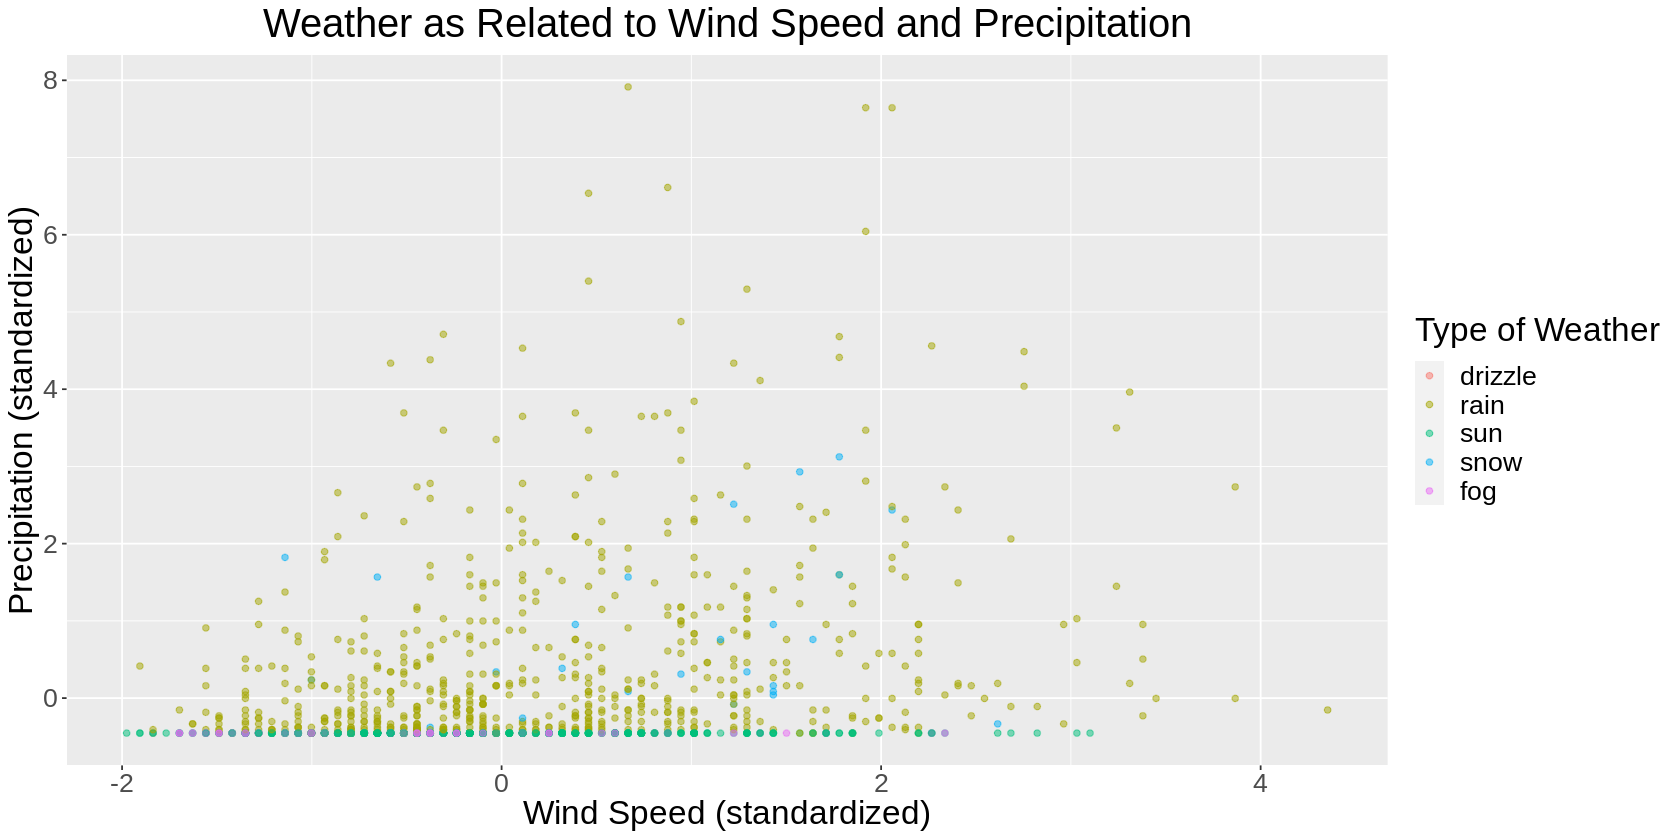

In [35]:
options(repr.plot.width = 14, repr.plot.height = 7)
# Scale the weather data
weather_data_scaled <- weather_data %>%
    mutate(scaled_precipitation = scale(precipitation, center = TRUE),
          scaled_wind = scale(wind, center = TRUE),
          scaled_temp_avg = scale(temp_avg, center = TRUE))
# Create a scatterplot using ggplot
plot <- weather_data_scaled %>% 
    ggplot(aes(x = scaled_wind, y = scaled_precipitation)) +
    geom_point(aes(color = weather), alpha = 0.5) +
    labs(title = "Weather as Related to Wind Speed and Precipitation", color = "Type of Weather") +
    xlab("Wind Speed (standardized)") +
    ylab("Precipitation (standardized)") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
plot

We can see that ....

## Data Analysis

### Method Overview

Here we perform ... ... write stuff here

In [14]:
set.seed(100)

In [17]:
# We split the data set into training and testing sets
weather_split <- initial_split(weather_data, prop = 0.75, strata = weather)
weather_train <- training(weather_split)
weather_test <- testing(weather_split)

## Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References

- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).

R, A. (2022, January 17). Weather Prediction. Kaggle. Retrieved March 11, 2022, from https://www.kaggle.com/ananthr1/weather-prediction

- why/how we chose predictor variables / how weather is related to these variables
- why our question is important